## Analysing kNN accuracy

### 1. Load and clean data

Set the enviroment and change the path to the folder containing the data

In [1]:
# change the path to your folder i.e.
# setwd("Semester_Project/report_figures")

options(warn = -1)

suppressMessages({
  library(tidyverse)
  library(cowplot)
  library(data.table)
})

options(dplyr.summarise.inform = FALSE)

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }
 
## color blind palletes
# https://personal.sron.nl/~pault/#sec:qualitative 
#https://thenode.biologists.com/data-visualization-with-flying-colors/research/ 

bright = c("#4477AA","#66CCEE","#228833","#CCBB44","#EE6677","#AA3377","#BBBBBB")


Loading data, adding colnames

In [2]:
raw_data = read.table ("knn_accuracy.tsv",header=F)

        
colnames(raw_data) =  c("id","dataset","model","fixed_curvature","universal","seed","Accuracy")


xtabs(~model+dataset+fixed_curvature,raw_data)



, , fixed_curvature = False

          dataset
model      adipose celegans rgc uc_epi
  e12            0        0   0      0
  e2             0        0   0      0
  e2,h2,s2       0        0   0      0
  e24            0        0   0      0
  e4,h4,s4      11       60  70     60
  e6             0        0   0      0
  e8,h8,s8       0        0   0      0
  h12           11       60  70     60
  h2             0        0   0      0
  h24            0        0   0      0
  h6             0        0   0      0
  s12           11       60  70     60
  s2             0        0   0      0
  s24            0        0   0      0
  s6             0        0   0      0
  u4,u4,u4      11       60  70     60

, , fixed_curvature = True

          dataset
model      adipose celegans rgc uc_epi
  e12           11       60  70     60
  e2            11       60  70     60
  e2,h2,s2      11       60  70     60
  e24           11       60  70     60
  e4,h4,s4      11       60  70     60
  e6     

Parse the description of the latent space

In [3]:
raw_data %>% pull(model) %>% gsub("[a-z]","",.) %>% gsub (",","+",.) -> astring

raw_data$n_dim=sapply(c(1:length(astring)), function (S) {
	eval(parse(text=astring[S]))})

raw_data$model = raw_data$model %>% toupper
raw_data$components = raw_data$model %>% gsub("[0-9]","",.)

Removing 3 models with low accuracy, where learned curvature exploaded.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0150  0.6710  0.7420  0.7236  0.8140  0.9274 

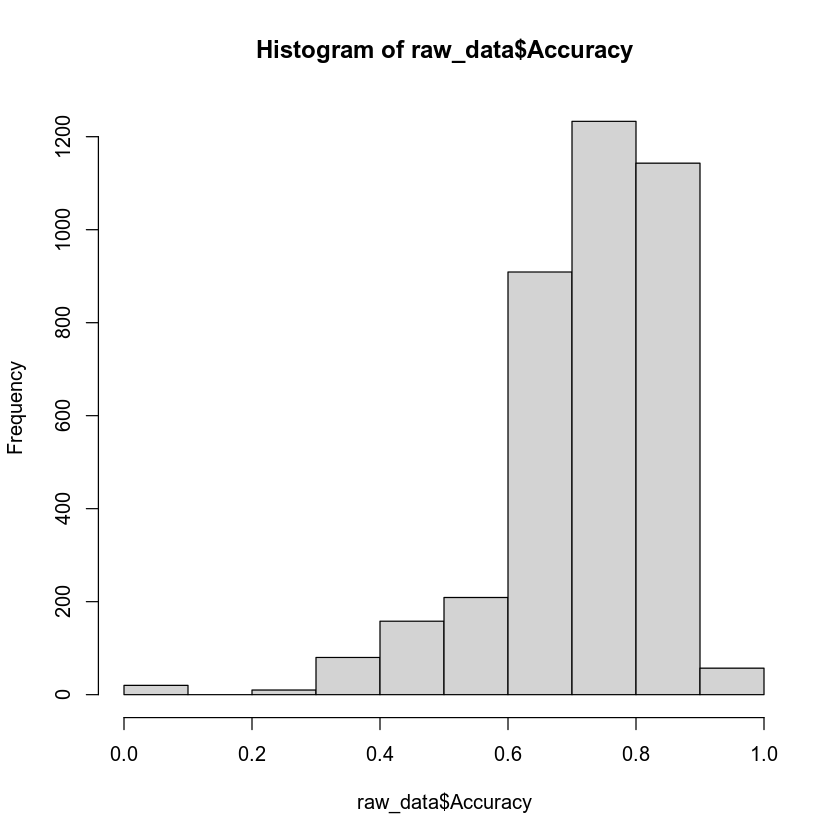

In [4]:
raw_data$Accuracy %>% summary

raw_data$accuracy=NULL 
hist(raw_data$Accuracy)


raw_data %>% filter(!(fixed_curvature == "False" & Accuracy < 0.5 & n_dim>2)) -> raw_data

### 2. Summarising data 

In [5]:
## averaging replicates within the same model/seed combination

raw_data %>% filter( dataset != "adipose") %>%
     group_by(id, dataset,model, seed,
              fixed_curvature, universal, components, n_dim) %>%

    summarise(
            Accuracy = mean(Accuracy)
            ) -> averaged_repl_data_without_adipose

raw_data %>% 
    filter( dataset == "adipose") %>%
    select(id,dataset,model,seed,fixed_curvature,universal,components,n_dim,Accuracy) %>%
    rbind (.,averaged_repl_data_without_adipose) -> clean_data

clean_data %>%
     group_by(model, dataset,
              fixed_curvature, universal,components, n_dim) %>%
    summarise(
             Mean = mean(Accuracy),
             Sd = sd(Accuracy),
             n = n()
            ) %>% arrange(dataset, n_dim) -> summary_data



summary_data 

model,dataset,fixed_curvature,universal,components,n_dim,Mean,Sd,n
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
E2,adipose,True,False,E,2,0.8516955,0.014247457,11
H2,adipose,True,False,H,2,0.8478691,0.012329344,11
S2,adipose,True,False,S,2,0.8515635,0.012248311,11
"E2,H2,S2",adipose,True,False,"E,H,S",6,0.8915424,0.012803282,11
E6,adipose,True,False,E,6,0.9056604,0.012834654,11
H6,adipose,True,False,H,6,0.8997229,0.014821904,11
S6,adipose,True,False,S,6,0.9010424,0.009623379,11
E12,adipose,True,False,E,12,0.8956327,0.015865297,11
"E4,H4,S4",adipose,False,False,"E,H,S",12,0.8887716,0.013322246,11


### 3. Plotting data, fixed curvature

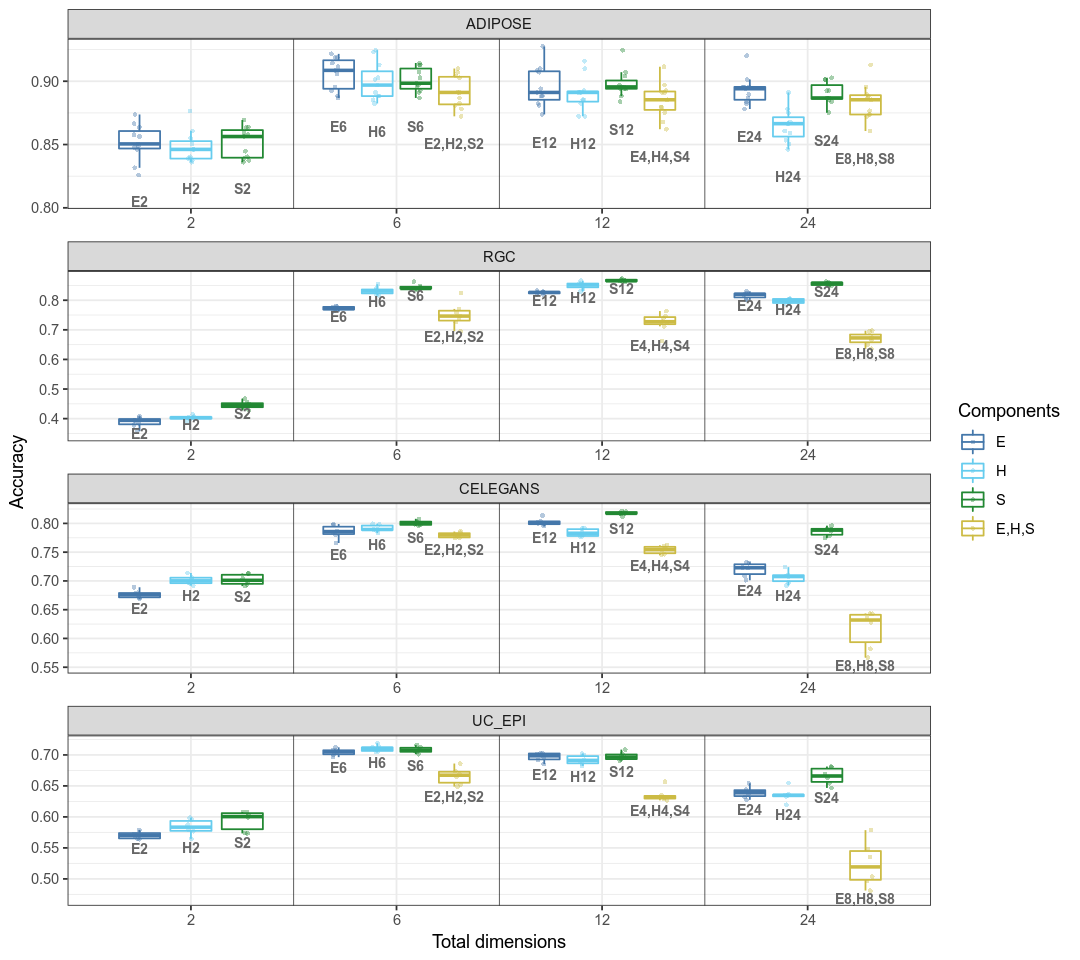

In [6]:
fig (9,8)


# getting labels for plotting
clean_data %>%    filter(fixed_curvature=="True") %>%
    mutate(
	dataset = factor(toupper(dataset),
        levels =toupper(c("adipose","rgc","celegans","uc_epi")),ordered = T),
	components = factor(components, levels=c("E","H","S","E,H,S"),ordered = F),
	components_dim = factor(paste(components,n_dim,sep="")),
	components_dim= fct_inorder((components_dim))) %>%
	as.data.frame %>% 
    group_by (dataset,n_dim,model, components,components_dim) %>%
    summarize(ymin=min(Accuracy),
              ymax = max(Accuracy))-> data_labels

data_labels$adj=data_labels$ymin-0.025*(data_labels$ymin)
	
data_labels$adj[data_labels$dataset=="adipose" ]=
    data_labels$ymin[data_labels$dataset=="adipose" ]-0.015*(data_labels$ymin[data_labels$dataset=="adipose"])


# plotting fixed curvature

clean_data %>% 
   
    filter(fixed_curvature=="True") %>%
    mutate(
	dataset = factor(toupper(dataset),
                     levels=toupper(c("adipose","rgc","celegans","uc_epi")),
                     ordered = T),
	components = factor(components, levels=c("E","H","S","E,H,S"),ordered = F),
	components_dim = factor(paste(components,n_dim,sep="")),
	components_dim= fct_inorder((components_dim))) %>%
	as.data.frame %>% 

	ggplot( aes(y=Accuracy,x=factor(n_dim),
                group = components_dim,
                color= components))+
	geom_point(position=position_jitterdodge(jitter.width=0.1,dodge.width=0.8),
               alpha=0.4,shape=16,size=1)+
	geom_boxplot(position=position_dodge2(width=0.6,padding=0.2),
                 outlier.alpha=0,
                fill=NA)+
    facet_wrap(~dataset,ncol=1,scales="free")+
	geom_vline(xintercept=1.5,color="grey10",size=0.2)+
	geom_vline(xintercept=2.5,color="grey10",size=0.2)+
	geom_vline(xintercept=3.5,color="grey10",size=0.2)+
	geom_text(data=data_labels,aes(y=adj,label=model,angle=0),
              position=position_dodge(width=0.75),size=3, fontface="bold",color="grey40")+
    scale_color_manual(values=bright, name="Components")+
	xlab("Total dimensions")+
	ylab("Accuracy")+
	theme_bw()

if(0){
ggsave("all_datasets_accuracy_fixed.pdf",w=9,h=8)
    }

### 4. Plotting data, fixed vs nonfixed curvature and universal model

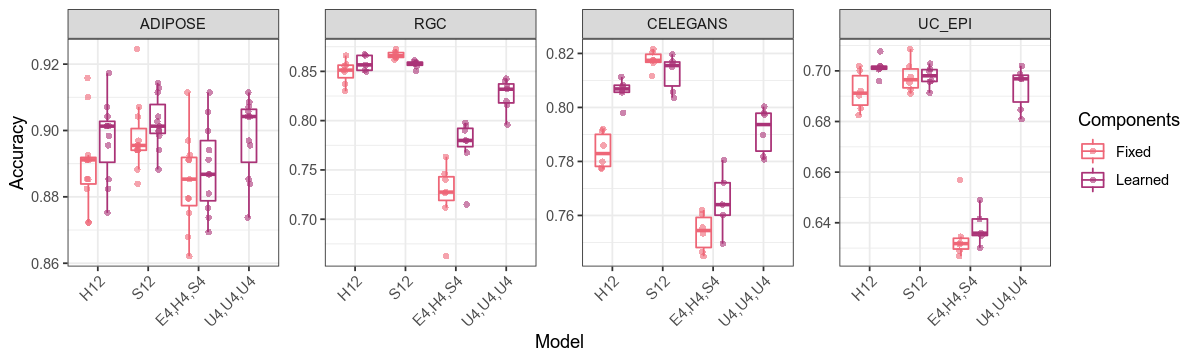

In [7]:
fig (10,3)

# plotting fixed curvature

clean_data %>% 
    
    filter (model%in%c("H12","S12","E4,H4,S4","U4,U4,U4")) %>%
    mutate(
	dataset = factor(toupper(dataset),
                     levels=toupper(c("adipose","rgc","celegans","uc_epi")),
                     ordered = T),
	components = factor(components, levels=c("H","S","E,H,S","U,U,U"),ordered = F),
	model = factor(model, levels=c("H12","S12","E4,H4,S4","U4,U4,U4"),ordered = F),
    curvature = c("Learned","Fixed")[factor(fixed_curvature)])  %>%

	as.data.frame %>% 

ggplot( aes(y=Accuracy,x=model,
            color= curvature,
            group= paste(curvature,model)
           ))+
	geom_point(position=position_jitterdodge(jitter.width=0.05,dodge.width=0.8),
               alpha=0.6,shape=16,size=1.5)+
	geom_boxplot(position=position_dodge2(width=0.6,padding=0.2,preserve = "single"),
                 outlier.alpha=0,
                fill=NA)+
    facet_wrap(~dataset, nrow=1, scales="free")+
    scale_color_manual(values=bright[c(5,6)], name="Components")+
	xlab("Model")+
	ylab("Accuracy")+
	theme_bw()+
    theme(axis.text.x= element_text(angle=45,vjust=1,hjust=1))


if(0){
    
ggsave("all_datasets_accuracy_fixed_vs_learned.pdf",w=10,h=3)

}

In [8]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS/LAPACK: /home/spot/.conda/envs/lsp/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] data.table_1.14.2 cowplot_1.1.1     forcats_0.5.1     stringr_1.4.0    
 [5] dplyr_1.0.9       purrr_0.3.4       readr_2.1.2       tidyr_1.2.0      
 [9] tibble_3.1.7      ggplot2_3.3.6     tidyverse_1.3.1  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-7     tidyselect_1.1.2 repr_1.1.4       haven_2.